<a href="https://colab.research.google.com/github/timothy-voiuhy/CrackDetection/blob/main/crack_yolo_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 36.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import glob
import json
import yaml
import cv2

import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# setup dataset directory
try:
    from google.colab import drive
    drive.mount("/content/drive")
    yolo_project_dir= "/content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1"
    local_dataset_dir = "/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/"
    lastModel = "/content/drive/MyDrive/Models/Yolo_Cracks_Segmentation/train/weights/last.pt"
    bestModelPath = "/content/drive/MyDrive/Models/Yolo_Cracks_Segmentation/train/weights/best.pt"
except Exception as e:
    local_dataset_dir = "/home/kali/AI_ML/DATA/CCSS-DATA-V4-withVal/benchmarkingDatasets/"
    bestModelPath = "./CSModel.pt"
YOLO_YAML_FILE = local_dataset_dir+"yolo_dataset/data.yaml"

Mounted at /content/drive


In [ ]:
local_dataset_dir

'/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/'

In [ ]:
# !kaggle datasets download -d parniashokri/ccssdata
# !unzip ccssdata.zip
# !mkdir BACKUP
# !cp -r CCSS-DATA-V4-withVal BACKUP
# !mkdir /content/datasets/
# ! rm -rf CCSS-DATA-V4-withVal
# ! cp -r BACKUP/CCSS-DATA-V4-withVal /content/datasets/
# !ls ./CCSS-DATA-V4-withVal/benchmarkingDatasets/
# !mv ./CCSS-DATA-V4-withVal /content/datasets/
!ls /content/datasets/

CCSS-DATA-V4-withVal


In [ ]:
input_dir_path= local_dataset_dir+"input/"
non_dir = local_dataset_dir+"train/noAugmentation-noPatch"
train_dir = local_dataset_dir+"train/traditionalAugmentation-withPatch/"
# train_images_dir = input_dir_path+"train"

In [ ]:
def organizeDir():
    if os.path.isdir(non_dir):
        shutil.rmtree(non_dir)
        for dir_name in os.listdir(train_dir):
            dir_path = os.path.join(train_dir, dir_name)
            shutil.move(dir_path, os.path.join(local_dataset_dir, 'train'))
        os.rmdir(train_dir)

    if not os.path.isdir(input_dir_path):
        os.mkdir(input_dir_path)

    for dir_name in os.listdir(local_dataset_dir):
        dir_path = os.path.join(local_dataset_dir, dir_name)
        if dir_name != "input":
            img_dir = os.path.join(dir_path, "img")
            mask_dir = os.path.join(dir_path, "lbl")
            new_img_dir = os.path.join(dir_path, f"{dir_name}Images")
            new_mask_dir = os.path.join(dir_path, f"{dir_name}Masks")
            if not os.path.isdir(new_mask_dir):
                os.rename(img_dir, new_img_dir)
                os.rename(mask_dir, new_mask_dir)
                shutil.move(new_img_dir, input_dir_path)
                shutil.move(new_mask_dir, input_dir_path)
                os.rmdir(dir_path)

    train_mask_dir = os.path.join(input_dir_path, "trainMasks")
    validation_mask_dir = os.path.join(input_dir_path, "validationMasks")
    test_mask_dir= os.path.join(input_dir_path, "testMasks")

    train_cracks_category_dir = os.path.join(train_mask_dir, "crack")
    val_cracks_category_dir = os.path.join(validation_mask_dir, "crack")
    test_cracks_category_dir = os.path.join(test_mask_dir, "crack")

    if not os.path.isdir(train_cracks_category_dir):
        if not os.path.isdir(train_cracks_category_dir):
            os.mkdir(train_cracks_category_dir)
            os.mkdir(val_cracks_category_dir)
            os.mkdir(test_cracks_category_dir)

        # Move files using shutil and glob instead of os.system
        for file_path in glob.glob(os.path.join(train_mask_dir, "*.jpg")):
            shutil.move(file_path, train_cracks_category_dir)

        for file_path in glob.glob(os.path.join(validation_mask_dir, "*.jpg")):
            shutil.move(file_path, val_cracks_category_dir)

        for file_path in glob.glob(os.path.join(test_mask_dir, "*.jpg")):
            shutil.move(file_path, test_cracks_category_dir)
# Call organizeDir to execute the function
organizeDir()

In [ ]:
# generating the yolodataset format
# first we convert our dataset into a coco format

# needed: json file file in each of the train test and validation images directories

# json dict format
COCO_FORMAT = {
    "info": {},
    "licenses": [],
    "images": [],
    "categories": [],
    "annotations": []
}

PLACEHOLDER = 0

# each image in the images list above is of the format:
IMAGE_FORMAT= {
    "id":PLACEHOLDER,
    "width":PLACEHOLDER,
    "height": PLACEHOLDER,
    "filename": PLACEHOLDER
}

#each annotation in the annotation is of the format

ANNOTATION_FORMAT = {
    "iscrowd":PLACEHOLDER,
    "id":PLACEHOLDER,
    "image_id": PLACEHOLDER,
    "category_id": PLACEHOLDER,
    "bbox": PLACEHOLDER,
    "area": PLACEHOLDER,
    "segmentation": [PLACEHOLDER, PLACEHOLDER, ...]
}

In [ ]:
cracks_paths = glob.glob(os.path.join(local_dataset_dir+"input/trainImages/", "*.jpg"))

In [ ]:
category_ids = {
    "Crack":1,
}
annotations = []
images = []

def getImagesAnnotations(masks_path):
    image_id = 0
    annotation_id = 0

    annotations = []
    images = []

    cracks_dir = os.path.join(masks_path, "crack")
    mask_paths = glob.glob(os.path.join(cracks_dir, "*.jpg"))

    for mask_image in mask_paths:
        original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.jpg'
        mask_image_open = cv2.imread(mask_image)

        # Get image dimensions
        height, width, _ = mask_image_open.shape

        # Create or find existing image annotation
        if original_file_name not in map(lambda img: img['file_name'], images):
            image = {
                "id": image_id + 1,
                "width": width,
                "height": height,
                "file_name": original_file_name,
            }
            images.append(image)
            image_id += 1
        else:
            image = [element for element in images if element['file_name'] == original_file_name][0]

        # Find contours in the mask image
        gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

        # Create annotation for each contour
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            segmentation = contour.flatten().tolist()

            annotation = {
                "iscrowd": 0,
                "id": annotation_id,
                "image_id": image['id'],
                "category_id": 1,
                "bbox": bbox,
                "area": area,
                "segmentation": [segmentation],
            }
            # Add annotation if area is greater than zero
            if area > 0:
                annotations.append(annotation)
                annotation_id += 1
    return images, annotations, annotation_id

def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = getImagesAnnotations(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

In [ ]:
train_mask_path = os.path.join(local_dataset_dir+"input", "trainMasks")
train_json_path = local_dataset_dir+"input/trainImages/train.json"
process_masks(train_mask_path, train_json_path)

val_mask_path = os.path.join(local_dataset_dir+"input", "validationMasks")
val_json_path = local_dataset_dir+"input/validationImages/val.json"
process_masks(val_mask_path, val_json_path)

test_mask_path = os.path.join(local_dataset_dir+"input", "testMasks")
test_json_path = local_dataset_dir+"input/testImages/test.json"
process_masks(test_mask_path, test_json_path)

Created 28564 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/trainMasks
Created 2065 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/validationMasks
Created 2500 annotations for images in folder: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/input/testMasks


# The ultralytics yolo dataset format:
The dataset label format used for traiing YOLO segmentation models is as follows
1. Onet text file per image. Each image in the dataset has a corresponding text file with the same name as the image ile and the ".txt" file extension.
2. One row per object: Each row in the text file  corresponds to one object instance in the image.
3. Object information per row: Each row contains the following information about the object instance:
    Object class index: An interger representing the class of the object(eg 0 for       person , 1 for car etc).
    Object bounding coordinates: The bounding coordinates around the mask area, normalized to be between 0 and 1.

The format for a single row in the segmentation dataset file is as follows:
<\class-index> <\x1> <\y1> <\x2> <\y2> ... <\xn> <\yn>

In [ ]:
# now we change the coco format to yolo format
# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".jpg"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    # Number of classes
    nc = len(names)
    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }
    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


In [ ]:
base_input_path = local_dataset_dir+"input/"
base_output_path = local_dataset_dir+"yolo_dataset/"

# Processing validation dataset (if needed)
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "validationImages"),
    input_json_path=os.path.join(base_input_path, "validationImages/val.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

# Processing training dataset
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "trainImages"),
    input_json_path=os.path.join(base_input_path, "trainImages/train.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels")
)

convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "testImages"),
    input_json_path=os.path.join(base_input_path, "testImages/test.json"),
    output_images_path=os.path.join(base_output_path, "test/images"),
    output_labels_path=os.path.join(base_output_path, "test/labels")
)

In [ ]:
    # Creating the YAML configuration file
create_yaml(
    input_json_path=os.path.join(base_input_path, "trainImages/train.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path=local_dataset_dir+"yolo_dataset/train/images",
    val_path=local_dataset_dir+"yolo_dataset/valid/images",
    test_path=local_dataset_dir+"yolo_dataset/test/images"
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU found")
else:
    print("GPU not found. Using CPU")
    device = torch.device("cpu")

GPU found


In [ ]:
# training the yolo model on the data
model = YOLO("yolo11n.pt")


100%|██████████| 5.35M/5.35M [00:00<00:00, 272MB/s]


In [ ]:
results = model.train(
    data = YOLO_YAML_FILE,
    epochs = 30,
    project = yolo_project_dir,
    batch = 32,
    verbose= True,
    save = True,
    device = device,
    patience = 5
)

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/data.yaml, epochs=30, time=None, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/train/labels... 2648 images, 134 backgrounds, 0 corrupt: 100%|██████████| 2782/2782 [00:03<00:00, 785.14it/s]


train: New cache created: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/valid/labels... 176 images, 5 backgrounds, 0 corrupt: 100%|██████████| 181/181 [00:00<00:00, 275.13it/s]

val: New cache created: /content/datasets/CCSS-DATA-V4-withVal/benchmarkingDatasets/yolo_dataset/valid/labels.cache


Plotting labels to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.18G      1.878      2.671      1.611        339        640: 100%|██████████| 87/87 [01:53<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]

                   all        181       2065      0.155     0.0673     0.0304     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.28G      1.964      2.344       1.61        280        640: 100%|██████████| 87/87 [01:48<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        181       2065      0.146      0.091     0.0394     0.0154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       6.8G      1.947      2.227      1.596        309        640: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        181       2065      0.116     0.0726     0.0318     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       6.3G      1.937      2.183      1.586        255        640: 100%|██████████| 87/87 [01:48<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

                   all        181       2065      0.127     0.0881     0.0398     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.09G      1.867        2.1      1.557        298        640: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]

                   all        181       2065      0.158     0.0872      0.046      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       5.9G      1.824      2.067      1.526        348        640: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

                   all        181       2065      0.128     0.0915     0.0406     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.28G      1.782      2.006      1.504        249        640: 100%|██████████| 87/87 [01:47<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

                   all        181       2065      0.174      0.108     0.0576     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.22G      1.731      1.963      1.477        411        640: 100%|██████████| 87/87 [01:43<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

                   all        181       2065      0.211      0.119     0.0767     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.44G      1.712      1.949      1.465        339        640: 100%|██████████| 87/87 [01:46<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all        181       2065      0.212      0.127     0.0725      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.31G      1.676      1.891      1.444        380        640: 100%|██████████| 87/87 [01:44<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

                   all        181       2065      0.217       0.13     0.0821     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.32G      1.633      1.847       1.43        357        640: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all        181       2065      0.239      0.112     0.0793     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.58G      1.633      1.837      1.426        316        640: 100%|██████████| 87/87 [01:44<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]

                   all        181       2065       0.23       0.12     0.0885     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.79G       1.63      1.828      1.414        320        640: 100%|██████████| 87/87 [01:49<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

                   all        181       2065      0.282      0.128     0.0989      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.15G      1.601       1.79      1.396        347        640: 100%|██████████| 87/87 [01:48<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all        181       2065      0.293      0.129       0.11     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.06G      1.582      1.776      1.396        355        640: 100%|██████████| 87/87 [01:47<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all        181       2065      0.259      0.138      0.102     0.0502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.84G      1.558      1.745      1.381        276        640: 100%|██████████| 87/87 [01:49<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all        181       2065      0.258      0.129     0.0965     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.59G      1.544       1.73      1.383        340        640: 100%|██████████| 87/87 [01:48<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        181       2065       0.27      0.135      0.105     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.74G      1.523      1.715      1.365        452        640: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        181       2065      0.283      0.149      0.113     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.21G      1.504      1.678      1.348        318        640: 100%|██████████| 87/87 [01:48<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        181       2065      0.294      0.142      0.114      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.92G      1.498      1.684      1.343        248        640: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        181       2065      0.285      0.135      0.111     0.0552


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.49G      1.711       1.96      1.508        248        640: 100%|██████████| 87/87 [01:09<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        181       2065      0.321      0.139      0.119     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.25G      1.691      1.926      1.492        185        640: 100%|██████████| 87/87 [01:07<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        181       2065      0.323       0.14      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.36G      1.672      1.894      1.489        215        640: 100%|██████████| 87/87 [01:04<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]

                   all        181       2065       0.31      0.142      0.127     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.19G      1.654      1.876      1.473        293        640: 100%|██████████| 87/87 [01:04<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        181       2065      0.292      0.154      0.123     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.69G      1.647      1.863      1.471        159        640: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        181       2065      0.346      0.149      0.131     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.64G       1.62      1.829       1.45        194        640: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        181       2065      0.311      0.158      0.131     0.0687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.92G      1.592      1.814      1.441        210        640: 100%|██████████| 87/87 [01:04<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        181       2065      0.305      0.155      0.129     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.81G      1.569      1.775      1.422        186        640: 100%|██████████| 87/87 [01:05<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        181       2065      0.342      0.154      0.139     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.04G      1.558      1.759      1.415        251        640: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        181       2065      0.336      0.161      0.142     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.72G      1.539      1.731      1.397        177        640: 100%|██████████| 87/87 [01:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

                   all        181       2065       0.34      0.157      0.146     0.0779



30 epochs completed in 0.826 hours.
Optimizer stripped from /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


                   all        181       2065       0.34      0.157      0.146     0.0782
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/drive/MyDrive/Models/Yolo_Cracks_SegmentationV1/train


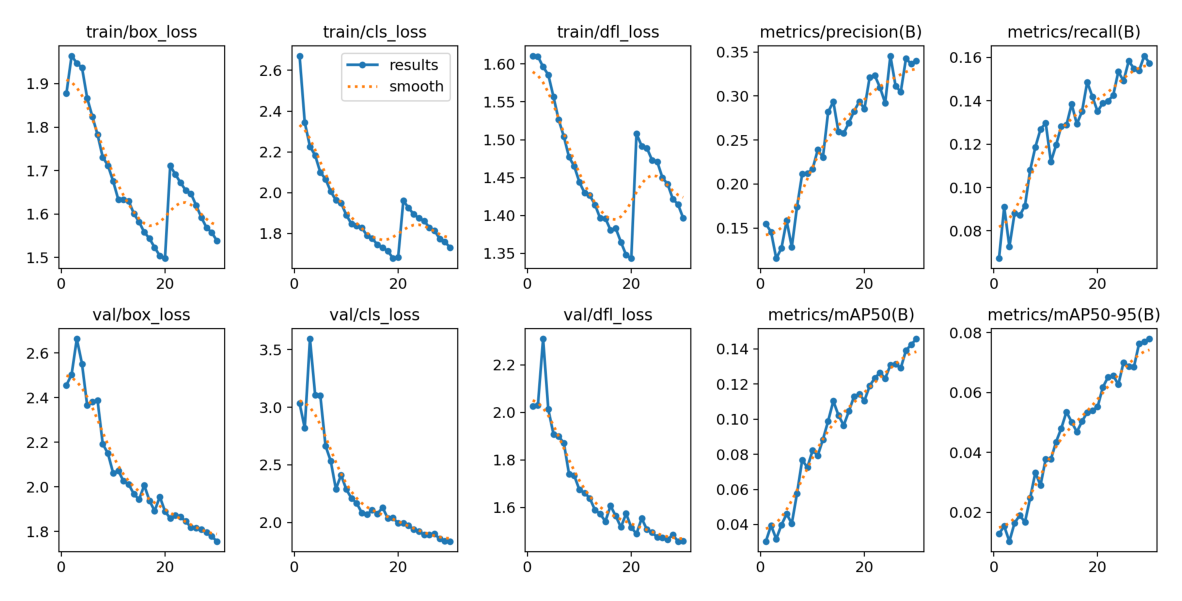

In [ ]:
# the Results graphs images
image_path = os.path.join(yolo_project_dir, "train/results.png")
image = Image.open(image_path)
# image.show()
plt.figure(figsize=(15, 30))
plt.imshow(image)
plt.axis('off')
plt.show()

Results interpretation:

#Training Loss Curves:

###Train/box_loss:
This curve shows the loss for the bounding box regression. It generally decreases over epochs, indicating the model is getting better at predicting the location and size of cracks.
###Train/cls_loss:
This curve shows the loss for the classification of objects within the bounding boxes. A decreasing trend here suggests the model is improving at identifying cracks.
###Train/dfl_loss:
 This curve shows the loss for the detection head, which predicts the presence of objects and their confidence scores. A decreasing trend here indicates the model is getting better at detecting cracks.

#Validation Loss Curves:

###Val/box_loss:
This curve shows the loss for the bounding box regression on the validation set. A decreasing trend here is ideal, but it's possible to see some fluctuations due to the variability of validation data.
###Val/cls_loss:
This curve shows the classification loss on the validation set. Similar to the training loss, a decreasing trend is desired.
###Val/dfl_loss:
This curve shows the detection head loss on the validation set. A decreasing trend here indicates the model is improving at detecting cracks on unseen data.

#Metrics:

###metrics/precision(B):
This metric measures the proportion of true positive detections among all positive predictions. A higher value indicates better precision.
###metrics/recall(B):
 This metric measures the proportion of true positive detections among all actual positive instances. A higher value indicates better recall.
###metrics/mAP50(B):
This metric is the mean Average Precision at an Intersection over Union (IoU) threshold of 0.5. It provides a more comprehensive measure of the model's performance.
###metrics/mAP50-95(B):
 This metric is similar to mAP50 but considers a wider range of IoU thresholds (0.5 to 0.95). It provides a more stringent evaluation of the model's performance.

#Overall Observations:

The training losses for all three components (box, cls, and dfl) are generally decreasing, indicating that the model is learning.
The validation losses are also generally decreasing, suggesting that the model is generalizing well to unseen data.
The precision and recall metrics are increasing, which is a good sign.
The mAP50 and mAP50-95 metrics are also increasing, indicating that the model's performance is improving overall.

In [ ]:
stats_dir = "./cracksSegmentation/train2"

def visualize_images(directory):
    # Filter out non-image files by checking file extensions
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Define the grid size for visualization (e.g., 3x3, or adjust as needed)
    num_images = len(image_files)
    cols = 3
    rows = (num_images // cols) + (num_images % cols > 0)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    # Loop through each image file and display it
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(image_file)
        axes[i].axis('off')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_images(stats_dir)